# 4 урок. 2 задание.

## Задание.
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2024-06-28 по 2024-07-04 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

## Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse
from scipy import stats
from matplotlib import pyplot as plt

## Подключение к БД и подгрузка данных

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240720',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2024-06-28' and '2024-07-04'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

In [4]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,13,44,0.295455
9,2,24239,40,90,0.444444


## Визуальный анализ данных

In [38]:
#Разибваем датафрейм на группы для удобства
group_a = df[df['exp_group'] == 1].copy()
group_b = df[df['exp_group'] == 2].copy()
group_a.ctr.mean(), group_b.ctr.mean()

(0.216773994120072, 0.2161016893237817)

Фактически по результатам теста ctr практически не изменился

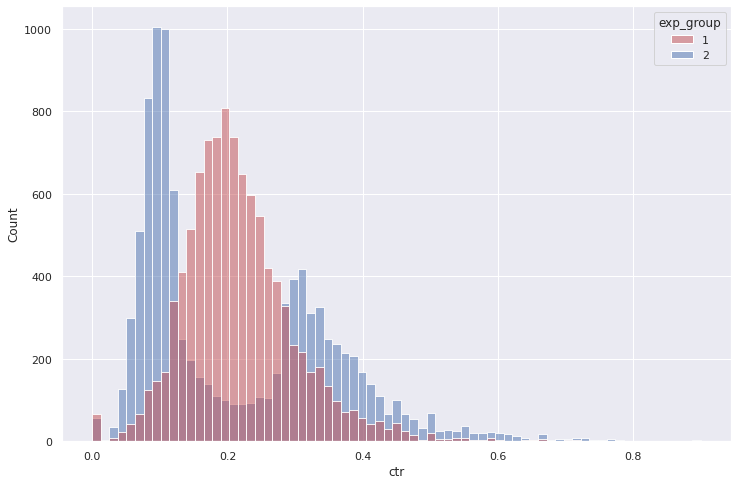

In [16]:
sns.set(rc={'figure.figsize':(12,8)}) # меняем размер графиков
sns.histplot(df,
             x='ctr',
             hue='exp_group',
             alpha=0.5,
             palette = ['r', 'b']
            )
plt.show()

### Выводы

Распределение в контрольной группе близко к нормальному, а вот распределение в тестовой группу совсем нет) Видно два горба.

Так же стоит отметить, что "первый горб" между 0 и 0.2 ctr выше, чем второй, между 0.2 и  0.4

Скорее в данной ситуации t-test покажет не совсем точные данные

## Тесты.

### Т-тест.

In [52]:
stats.ttest_ind(group_a.ctr,
                group_b.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

#### Выводы

p_value > 0.05, следовательно по т-тесту мы принимаем нулевую гипотезу и говорим, что разницы между контрольной и тестовой группой нет.

### Тест Манна-Уитни

In [18]:
stats.mannwhitneyu(group_a.ctr,
                   group_b.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

#### Выводы

Тест Манна-Уитни уже показывает другие данные. Он показывает, что различия в данных есть и они стат значимые.

Нулевая гипотеза звучит так P(X>Y)=P(Y>X)

И если посмотреть на распределение, то действительно можно увидеть, что вероятность вытащить значение из группы а выше, чем значение из группы б.

### Бутстреп

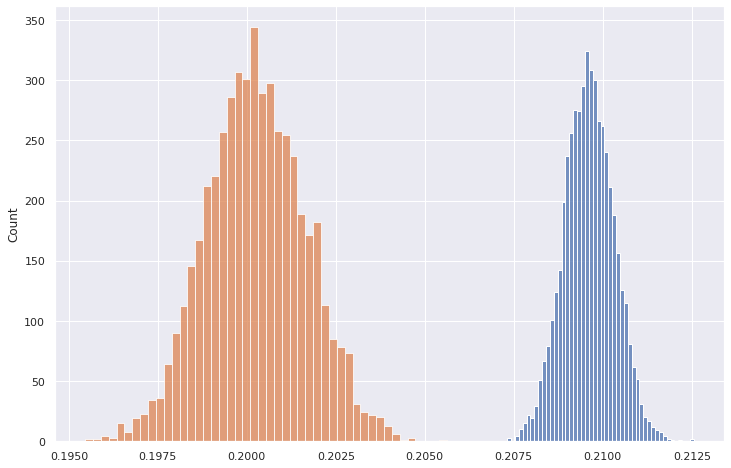

In [31]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=5000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = group_a.likes.to_numpy()
views1 = group_a.views.to_numpy()
likes2 = group_b.likes.to_numpy()
views2 = group_b.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)


sns.histplot(ctr1)
sns.histplot(ctr2)
plt.show()

In [24]:
stats.ttest_ind(ctr1, ctr2, equal_var=False)

Ttest_indResult(statistic=420.9257582549862, pvalue=0.0)

Наши распределения не имеют пересечений, поэтому ожидаемо ттест показывает pvalue = 0

#### Вывод

Судя по распределению глобальных ctr на Пуассновском Бутстрепе, видно, что тестовая группа набирает ~21% ctr а контрольная группа 20%

Так что судя по распределению новый алгоритм отрабатывает лучше

## Результат

В целом распределение после 

1) Мы проверяли результаты теста с помощью ттеста, теста Манна-Уитни и Пуассоновского Бутстрепа.
2) Мы провели 3 теста:
    * ttest показал, что различий в среднем ctr в двух группах нет и мы принимаем нулевую гипотезу. 
    * Тест Манна-Уитни показал стат значимость, потому что распределение в тестовой группе имеет двугорбый вид. Сдедовательно P(X>Y) != P(Y>X).
    * И при использовании Пуассоновского бутстрапа мы получили результат, в котором распределения стр в тестовой и контрольной группе не пересекаются и видно, что стр в тестовой группе выше, чем в контрольной.
3) Есть предположение, что алгоритм по подбору людей "похожих" на нашего пользователя работает не корректно и не всегда угадывает "похожую аудиторию", это могло бы объяснить ситуацию в которой мы либо угадали и показали человеку релевантные посты и соответственно получили результат с ctr ~0.3 и в то же время большое количетсво пользователей, которые получили не очень подходящие рекомендации и соответственно ctr опустился до 0.1
4) Я думаю, что не стоит раскатывать новый алгоритм, так как результат слишком не предсказуем, мы не видим стабильности в работе данной рекомендательной системе + большое количество пользователей с заниженным ctr может негативно сказаться в целом на пользовании нашим приложением и вызвать отток пользователей